# Polygons

## The Solution

In [1]:
import numpy as np
import pandas as pd
import itertools
import operator

from decimal import *
from decimal_math import sin, cos
from math import pi, sqrt, comb
from typing import List, Tuple, Set, Dict
from functools import cached_property, lru_cache
from matplotlib import pyplot as plt
from tqdm.auto import tqdm, trange

In [2]:
getcontext()

Context(prec=28, rounding=ROUND_HALF_EVEN, Emin=-999999, Emax=999999, capitals=1, clamp=0, flags=[], traps=[InvalidOperation, DivisionByZero, Overflow])

In [3]:
TOLERANCE = Decimal(1e-10)
PRECISION = 10

def zeroise(a: float or None) -> bool:
    if a is None:
        return None
    return a if abs(a) > TOLERANCE else 0

In [4]:
class Point:
    
    def __init__(self, x: float, y: float, precision=PRECISION):
        self.x = round(zeroise(Decimal(x)), precision)
        self.y = round(zeroise(Decimal(y)), precision)
        
    @classmethod
    def from_intersection(cls, L1:"LineSegment"=None, L2:"LineSegment"=None) -> "Point":
        '''
        Alternate constructor for Point via intersection of two LineSegments.
        '''
        a1, b1, c1 = (L1.p2.x - L1.p1.x), (L2.p1.x - L2.p2.x), (L2.p1.x - L1.p1.x)
        a2, b2, c2 = (L1.p2.y - L1.p1.y), (L2.p1.y - L2.p2.y), (L2.p1.y - L1.p1.y)
        
        D  = a1 * b2 - b1 * a2
        Dx = c1 * b2 - b1 * c2
        Dy = a1 * c2 - c1 * a2
        
        if D != 0:
            s = Dx / D
            t = Dy / D
            
            if not (0 <= s <= 1 and 0 <= t <= 1):
                return None
        else:
            return None
        
        return cls((1-s)*L1.p1.x + s*L1.p2.x, (1-s)*L1.p1.y + s*L1.p2.y)

    def reduced_precision(self, precision=PRECISION) -> "Point":
        x = round(zeroise(Decimal(self.x)), precision)
        y = round(zeroise(Decimal(self.y)), precision)
        return Point(x, y)
    
    def connecting_edges(self, polygon_solver) -> Set["LineSegment"]:
        '''
        Method by which the point becomes aware of its adjacent edges.
        Can be created at intersection time in the future.
        '''
        return polygon_solver.point_ls[self]
    
    @lru_cache(maxsize=None)
    def dependent_edges(self, polygon_solver) -> Set["LineSegment"]:
        '''
        Provides the edges that we depend on to calculate self.value.
        In approach one, these are the edges that point towards self.
        '''
        return set(edge for edge in self.connecting_edges(polygon_solver) if edge.direction(self))
        
    @lru_cache(maxsize=None)
    def value(self, polygon_solver) -> int:
        '''
        Recursively calculates the number of paths we can take from the start node to this node by summing over
            the nodes of dependent edges.
        '''
        if not self.dependent_edges(polygon_solver):
            return 1
        return sum(edge.other_end(self).value(polygon_solver) for edge in self.dependent_edges(polygon_solver))
    
    def show_dependencies(self, polygon_solver, n: int) -> List["Point"]:
        '''
        Returns the n-th level of dependent nodes in the graph.
        '''
        current = set([self])
        for i in range(n):
            current = set(edge.other_end(point) for point in current for edge in point.dependent_edges(polygon_solver))
        return sorted(list(current), key=operator.attrgetter('x', 'y'))
    
    def __eq__(self, other) -> bool:
        if isinstance(other, Point):
            return not zeroise(self.x - other.x) and not zeroise(self.y - other.y)
        raise TypeError(f'Unable to compare Point and {other}.')

    def __hash__(self):
        return hash((self.x, self.y))
    
    def __repr__(self) -> str:
        return f"Point({self.x}, {self.y})"

In [5]:
class LineSegment:
    def __init__(self, p1: "Point", p2: "Point"):
        self.p1, self.p2 = sorted([p1, p2], key=operator.attrgetter('x','y'))
        
    @cached_property
    def L2(self) -> float:
        return sqrt((self.p1.x - self.p2.x)**2 + (self.p1.y - self.p2.y)**2)
    
   
    @cached_property
    def mid(self) -> "Point":
        return Point((self.p1.x + self.p2.x)/2, (self.p1.y + self.p2.y)/2)
    
    def direction(self, pt:"Point"=None) -> bool:
        '''
        Provides the direction label for the graph, by comparing the L2 distances (p1-to-end, p2-to-end).
            True if p1-to-p2; False if p2-to-p1.
        
        If the argument <pt> is provided, then returns True if the direction is pointing towards <pt> (which
            should be one of the ends of the line segment).
        
        Caution: This method should only be used when there are no intersection points between self.p1 and self.p2.
            Otherwise, it does not return a useful directional label.
        '''
        direction = LineSegment(self.p1, END).L2 > LineSegment(self.p2, END).L2
        if pt is None:
            return direction
        else:
            return direction if pt == self.p2 else (not direction)

    @cached_property
    def gradient(self) -> Tuple[float, float]:
        '''
        Creates a tuple used in the visualisation of the direction.
        '''
        p1, p2 = self.p1, self.p2
        multiplier = 1 if self.direction() else -1
        x_coeff = 0 if p1.x == p2.x else 1
        delta = Decimal(0.01)
        
        if p2.y > p1.y:
            y_coeff = 1
        elif p1.y == p2.y:
            y_coeff = 0
        else:
            y_coeff = -1
        
        try:
            return (multiplier*x_coeff*delta, multiplier*y_coeff*delta*abs((p2.y - p1.y)/(p2.x - p1.x)))
        except (DivisionByZero, InvalidOperation):
            return (0, multiplier*delta)
    
    def other_end(self, p: "Point") -> "Point":
        '''
        Returns the other end of the line if one end is given, None otherwise.
        '''
        if p == self.p1:
            return self.p2
        elif p == self.p2:
            return self.p1
        else:
            return None
        
    def __eq__(self, other) -> bool:
        if isinstance(other, LineSegment):
            return self.p1 == other.p1 and self.p2 == other.p2
        return False
    
    def __hash__(self):
        return hash((self.p1, self.p2))
    
    def __repr__(self) -> str:
        return f"LineSegment({self.p1}, {self.p2})"    

In [6]:
END = Point(-1,0)
START = Point(1,0)

In [7]:
class PolygonSolver:
    def __init__(self, n, plot=False, **kwargs):
        '''
        Creating an instance will create the regular polygon.
        '''
        self.n = n
        self.polygon = self.create_regular_polygon(n)
        
        self.line_segments = None
        self.point_ls = None
        self.create_line_segments()
        
        if plot:
            self.plot_polygon_graph(**kwargs)

    @classmethod
    def find_next_coordinate(self, xy: Tuple[Decimal, Decimal], t: Decimal) -> Tuple[Decimal, Decimal]:
        '''
        Refer to https://en.wikipedia.org/wiki/Rotation_matrix for the mathematical grounding behind this.
        '''
        x, y = xy
        return Point(x*cos(t) - y*sin(t), x*sin(t) + y*cos(t), 25)
            
    @classmethod
    def create_regular_polygon(self, n: int) -> List[Tuple]:
        '''
        Defines a polygon as the List of (x,y) coordinates of the vertices.
        '''
        theta = Decimal(2/n * pi)
        polygon = []
        previous = START

        for i in range(n):
            polygon.append(previous)
            previous = self.find_next_coordinate((previous.x, previous.y), theta)
            
        return polygon
    
    @cached_property
    def lines(self) -> List[LineSegment]:
        return [LineSegment(a,b) for a,b in itertools.combinations(self.polygon, 2)]
    
    @cached_property
    def line2points(self) -> Dict[LineSegment, Set[Point]]:
        '''
        Contains the information of where each line is mapped to every point on it.
        '''
        line2points = dict()  
        for line in self.lines:
            line2points[line] = set([line.p1, line.p2])

        for a, b in itertools.combinations(self.lines, 2):
            point = Point.from_intersection(a,b)

            if point is not None:
                line2points[a].add(point)
                line2points[b].add(point)

        return line2points
    
    def create_line_segments(self) -> None:
        line_segments = set()
        point_ls = dict()
        
        for ls, p in self.line2points.items():
            if len(p) == 2:
                line_segments.add(ls)
            else:
                sorted_points = sorted([item.reduced_precision() for item in p], key=operator.attrgetter('x','y'))
                for previous, current in zip(sorted_points, sorted_points[1:]):
                    if previous != current:
                        edge = LineSegment(previous, current)
                        line_segments.add(edge)
                        for item in (previous, current):
                            if item not in point_ls:
                                point_ls[item] = set([edge])
                            else:
                                point_ls[item].add(edge)
                                
        self.line_segments = line_segments
        self.point_ls = point_ls

    def plot_polygon_graph(self, figsize:int=8, lines:bool=True, points:bool=True, values:bool=True,
                           point_size:float=1, head_width:float=0.03):
        x, y = [point.x for point in self.point_ls], [point.y for point in self.point_ls]

        # Configurations
        limit = 1.1
        head_width = head_width
        offset = -0.07

        fig, ax = plt.subplots(figsize=(figsize,figsize))
        ax.set_xlim(-limit, limit)
        ax.set_ylim(-limit, limit)
        ax.set_aspect('equal', adjustable='box')
        ax.grid(axis='both', alpha=0.2)

        # Lines
        if lines:
            for line in self.line_segments:
                color = next(ax._get_lines.prop_cycler)['color']
                ax.plot([line.p1.x, line.p2.x], [line.p1.y, line.p2.y], color=color)
                plt.arrow(x=line.mid.x, y=line.mid.y,
                          dx=line.gradient[0], dy=line.gradient[1],
                          lw=0, color=color, length_includes_head=True, head_width=head_width)

        # Points
        if points:
            ax.scatter(x, y, c="black", s=point_size)

        # Values
        if values:
            for pt in self.point_ls:
                plt.annotate(pt.value(self), (pt.x+offset, pt.y+offset))
    
    def check_intersections(self):
        '''
        Returns the total number of intersections for an even regular n-sided polygon.
        Formula from <https://www.math.uwaterloo.ca/~mrubinst/publications/ngon.pdf>
        '''
        def is_multiple(x: int, y: int) -> bool:
            return x % y == 0

        n = self.n
        d = is_multiple
        interior = (comb(n, 4) + (-5*n**3 + 45*n**2 - 70*n + 24)/24*d(n,2) - (3*n/2)*d(n,4) + (-45*n**2 + 262*n)/6*d(n,6)
                    + 42*n*d(n,12) + 60*n*d(n,18) + 35*n*d(n,24) - 38*n*d(n,30) - 82*n*d(n,42) - 330*n*d(n,60)
                    - 144*n*d(n, 84) - 96*n*d(n,90) - 144*n*d(n,120) - 96*n*d(n,210))
        
        try:
            assert self.n + interior == len(self.point_ls)
            print(f'n = {n}, total number of points = {len(self.point_ls)}')
        except AssertionError:
            diff = len(self.point_ls) - int(self.n) - int(interior)
            raise AssertionError(f'Theoretical number of points ({int(self.n)} + {int(interior)} = {int(self.n + interior)}) not equal to calculated number of points ({len(self.point_ls)}). Difference of {diff}.')
    
    @lru_cache(maxsize=None)
    def solve(self):
        return sorted(self.point_ls.keys(), key=operator.attrgetter('x', 'y'))[0].value(self)
    
    @lru_cache(maxsize=None)
    def progressive_solve(self):
        '''
        Intended as an alternative solver that allows us to progressively solve the graph.
        Allows us to see a progress bar with a marginal performance hit compared to PolygonSolver.solve().
        '''
        iterable = sorted(self.point_ls.keys(), key=operator.attrgetter('x', 'y'), reverse=True)
        for item in tqdm(iterable, total=len(iterable)):
            item.value(self)
        return iterable[-1].value(self)

In [8]:
%%time
# Solver - plotting is slow and not recommended for n>20
solver = PolygonSolver(n=80, plot=False, figsize=20, values=False, head_width=0.01, point_size=12)
solver.check_intersections()
solver.progressive_solve()

n = 80, total number of points = 1486641


RecursionError: maximum recursion depth exceeded while calling a Python object

### Debugging
#### Assertion errors
The following code below is used for debugging purposes when the assertion does not hold.

In [9]:
all_points = sorted(list(solver.point_ls.keys()), key=operator.attrgetter('x', 'y'))

In [10]:
def sliding_window_iter(iterable, size):
    # https://codereview.stackexchange.com/questions/239352/sliding-window-iteration-in-python
    iterables = itertools.tee(iter(iterable), size)
    window = zip(*(itertools.islice(t, n, None) for n,t in enumerate(iterables)))
    yield from window

In [11]:
similar_points = set()
for item in tqdm(sliding_window_iter(all_points, 5), total=len(all_points)):
    for a,b in itertools.combinations(item,2):
        if abs(a.x - b.x) < TOLERANCE and abs(a.y - b.y) < TOLERANCE:
            similar_points.add((a,b))
similar_points = list(similar_points)

In [12]:
similar_points

[]

#### Recursion errors
Recursion errors when a node is connected to itself. To debug, we need to find a node that is connected to itself. The connection may not be immediate; it could be connected to another node; which then links to another node, and then to itself.

In [13]:
recursive_points = []
for point in tqdm(solver.point_ls, total=len(solver.point_ls)):
    for edge in point.dependent_edges(solver):
        if edge.other_end(point) == point:
            recursive_points.append(point)

In [ ]:
recursive_points

In [ ]:
problematic_pt = sorted(solver.point_ls.keys(), key=operator.attrgetter('x', 'y'), reverse=True)[661774]

In [ ]:
problematic_pt

In [ ]:
# list(problematic_pt.dependent_edges(solver))[1].other_end(problematic_pt).value(solver)

### Batch run

In [ ]:
current_values = dict()

In [ ]:
def batch_solver(left_bound, right_bound):
    for n in range(left_bound, right_bound, 2):
        solver = PolygonSolver(n=n, plot=False, figsize=20, values=False, head_width=0.01, point_size=12)
        solver.check_intersections()
        current_values[n] = solver.progressive_solve()

In [ ]:
batch_solver(80,100)

### Computational time
We are currently running into problems where we take a long time to compute.

There are a few ways to improve this algorithm.
1. Exploit the symmetry in the graph along the x-axis to realise that for any point, $(x_1,y_1).value$ will be the same as $(x_1, -y_1).value$ and thus the calculation only needs to be done once.

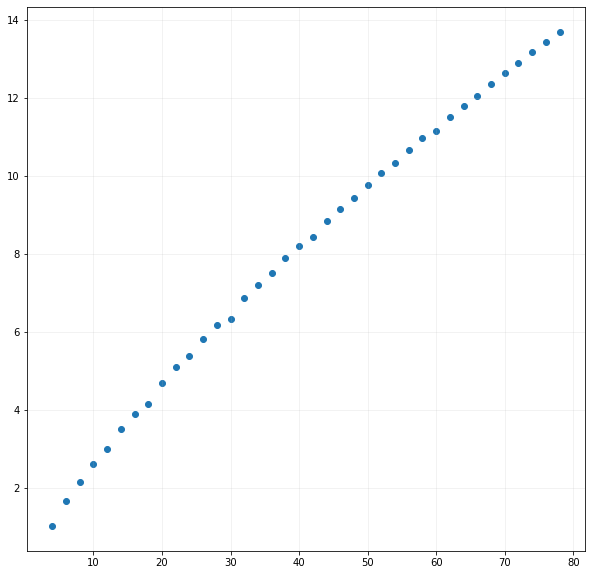

In [77]:
from results import solved_values
a,b = zip(*solved_values.items())

data = {
    'n': a,
    'paths': [Decimal(item) for item in b]
}

df = pd.DataFrame.from_dict(data)

# Analysis
df['ln_paths'] = df['paths'].apply(lambda x: x.ln())
df['ln_paths'] = df['ln_paths'].astype(np.float32)
df['cubert_ln_paths'] = np.cbrt(df['ln_paths'])

# Preparing final plot
df = df[['n', 'cubert_ln_paths']].copy()
fig, ax = plt.subplots(figsize=(10,10))
ax.grid(axis='both', alpha=0.2)
ax.scatter(x=df.n, y=df.cubert_ln_paths)

As the plot is close to linear, we think that the growth rate in $n$ (where $n$ is the number of sides of the polygon) is $e^{n^3}$.